In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates

In [3]:
import pandas_datareader as pdr

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 23.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.16.3-cp310-cp310-linux_x86_64.whl size=314460 sha256=fb9acf9c6b93671aa38cf622fd44bae2e3a6f2248ab3099728cce168830edbe8
  Stored in directory: /root/.cache/pip/wheels/c8/ac/6d/ad6d828725ffbe3abc508c95d25dd0c5fcc63539ae47913790
Successfully built peewee


In [4]:
import yfinance as yf
yf.pdr_override()

In [5]:
# Download historical data for SPY from Yahoo Finance
spy = yf.download('KCPSUGIND.NS', start='2005-01-01', end='2023-09-27')

# Split data into training (2010-2020) and validation (2020-2023) sets
training_data = spy['Adj Close']['2005-01-01':'2020-12-31']
validation_data = spy['Adj Close']['2021-01-01':'2023-09-27']

# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(spy)

In [6]:
# Feature scaling using MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

In [7]:
# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

In [8]:
print(X_train.shape,y_train.shape)

(3886, 60, 1) (3886,)


In [9]:
# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

In [10]:
# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=48, validation_data=(X_validation, y_validation))

Epoch 1/100
81/81 [==============================] - 24s 175ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 2/100
81/81 [==============================] - 12s 144ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/100
81/81 [==============================] - 12s 150ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/100
81/81 [==============================] - 12s 146ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/100
81/81 [==============================] - 12s 146ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 6/100
81/81 [==============================] - 12s 150ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 7/100
81/81 [==============================] - 12s 144ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/100
81/81 [==============================] - 12s 152ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/100
81/81 [==============================] - 12s 145ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/100
81/81 [==============================] - 12s 145ms/step - loss: 0.001

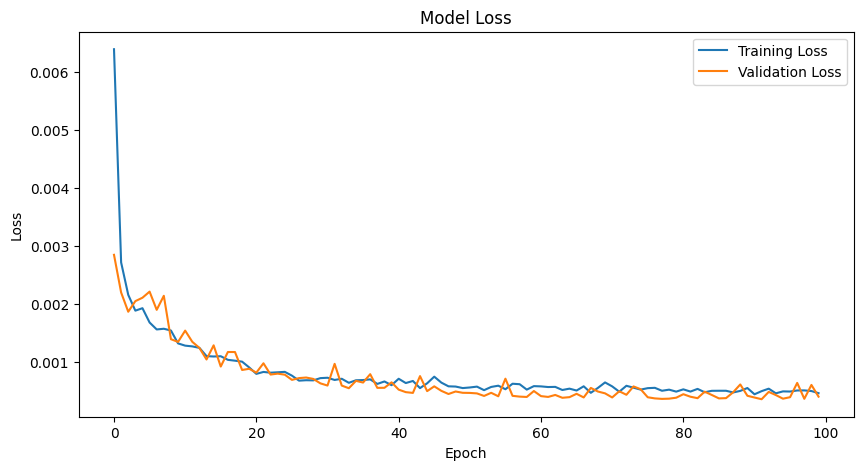

In [11]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Download test data for SPY from Yahoo Finance
spy_test = yf.download('KCPSUGIND.NS', start='2023-01-01', end='2023-09-27')

# Use 'Adj Close' prices as the test data
real_stock_price = spy_test['Adj Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
real_stock_price.shape

In [ ]:
# Preparing Test Data
dataset_total = pd.concat((spy['Adj Close'], spy_test['Adj Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(spy_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Making Predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [30]:
predicted_stock_price.shape

NameError: name 'predicted_stock_price' is not defined

In [ ]:

date_range = pd.date_range(start='2023-01-01', periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()

In [15]:
seq_length=60
# Initialize a sequence with historical data
current_sequence = spy_test[-seq_length:]
# print(X_test.shape,current_sequence.shape,predicted_stock_price.shape)

In [16]:
seq_length=60
# Initialize a sequence with historical data
current_sequence = spy_test[-seq_length:]['Adj Close']
current_sequence =current_sequence.values.reshape(-1,1)
current_sequence = sc.transform(current_sequence)
current_sequence =np.array(current_sequence)


In [ ]:
current_sequence = np.reshape(current_sequence, (1, current_sequence.shape[0], 1))
current_sequence.shape

In [17]:
# Assuming you have a trained LSTM model 'model' and historical data 'historical_data'
# 'prediction_horizon' is the number of future time steps you want to predict
# seq_length=60
# # Initialize a sequence with historical data
# current_sequence = spy_test[-seq_length:]['Adj Close'].reshape(-1, 1)
# current_sequence = sc.transform(current_sequence)
# Initialize an empty list to store future predictions
future_predictions = []
prediction_horizon=90
# Make predictions for the specified prediction horizon
for _ in range(prediction_horizon):
    # Reshape current_sequence to match the model input shape
    current_sequence = np.reshape(current_sequence, (1, current_sequence.shape[0], 1))
    
    # Use the model to predict the next time step
    next_prediction = model.predict(current_sequence)
    
    # Append the prediction to the future_predictions list
    future_predictions.append(next_prediction[0, 0])
    
    current_sequence = np.squeeze(current_sequence)
    # Update the current_sequence by removing the oldest value and adding the new prediction
    current_sequence = np.append(current_sequence[1:], next_prediction[0, 0])  # Add the

# future_predictions now contains predicted stock prices for the specified prediction horizon


1/1 [==============================] - 0s 38ms/step


In [23]:
future_predictions=np.asarray(future_predictions)
future_predictions.shape

(90,)

In [24]:
future_predictions=future_predictions.reshape(-1,1)
# future_predictions = sc.inverse_transform(future_predictions)

In [25]:
future_predictions.shape

(90, 1)

In [26]:
future_predictions = sc.inverse_transform(future_predictions)

In [31]:
future_predictions.shape

(90, 1)

In [29]:
# Print the number of predictions made for the specified prediction horizon
print("Number of predictions:", len(future_predictions))


Number of predictions: 90


In [28]:
spy_test.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-20,36.000000,37.299999,35.799999,36.349998,36.349998,887547
2023-09-21,36.299999,37.150002,34.049999,34.549999,34.549999,1221460
2023-09-22,34.799999,35.150002,33.750000,34.750000,34.750000,588034
2023-09-25,34.950001,37.599998,34.849998,36.500000,36.500000,2731006
2023-09-26,36.750000,36.750000,35.750000,36.200001,36.200001,566111


ValueError: x and y must have same first dimension, but have shapes (63,) and (182, 1)

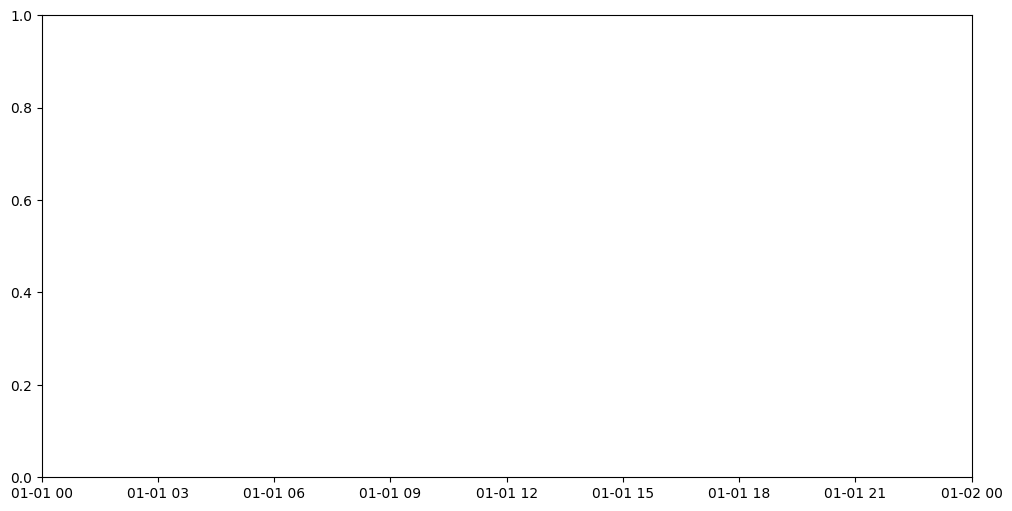

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming you have historical data for the past three months in 'real_stock_price' and predicted data for the next three months in 'predicted_stock_price'
real_stock_price = spy_test['Adj Close'].values.reshape(-1, 1)

# Create a date range for the past and predicted data
past_date_range = pd.date_range(start='2023-07-01', end='2023-09-27', freq='B')  # Historical data: Jan 2023 to Mar 2023
predicted_date_range = pd.date_range(start='2023-09-28', end='2023-12-30', freq='B')  # Predicted data: Apr 2023 to Jun 2023

# Visualize historical and predicted data on the same plot
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(past_date_range, real_stock_price, color='black', label='Historical SPY Stock Price')

# Plot predicted data
plt.plot(predicted_date_range, future_predictions, color='green', label='Predicted SPY Stock Price')

# Format x-axis to display month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show tick marks for every 1 month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.

plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.grid(True)  # Add gridlines for better visualization
plt.show()


In [ ]:
date_range = pd.date_range(start='2023-01-01', periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()

In [38]:
predicted_prices = future_predictions.reshape(-1,1)
predicted_prices.shape

(90, 1)

ValueError: x and y must have same first dimension, but have shapes (130,) and (182, 1)

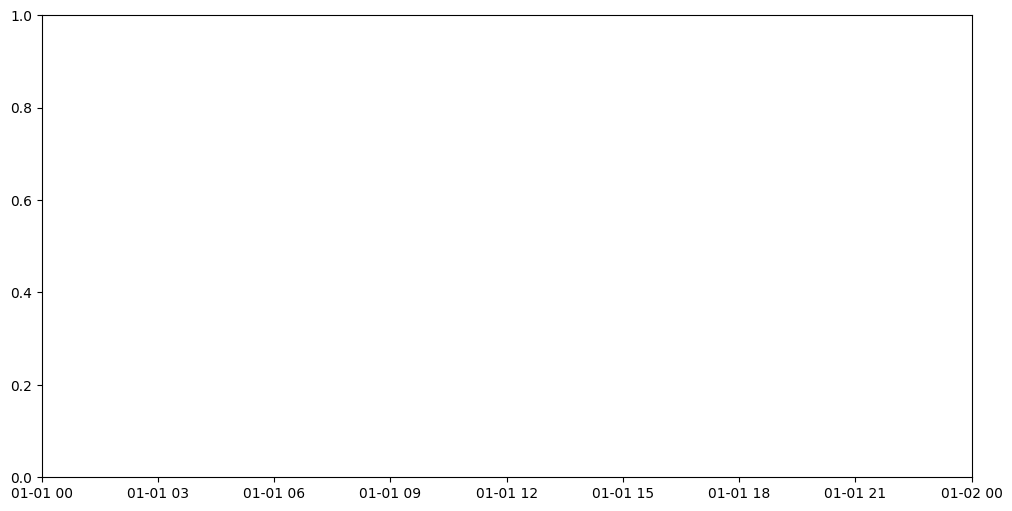

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Assuming you have historical data for the past and predicted data for the next 90 business days
# Define historical data and predicted prices (adjust these as needed)
historical_data = spy_test['Adj Close'].values.reshape(-1, 1)
predicted_prices = future_predictions.reshape(-1,1)  # Replace with your predicted prices

# Create date ranges for historical and predicted data
start_date = '2023-07-01'  # Adjust the start date as needed
end_date = '2023-12-30'    # Adjust the end date as needed

# Define a date range for historical data
historical_date_range = pd.date_range(start=start_date, end=end_date, freq='B')

# Define a date range for predicted data (next 90 business days)
predicted_date_range = pd.date_range(start=end_date, periods=len(predicted_prices), freq='B')

# Combine historical and predicted data
combined_data = np.concatenate((historical_data, predicted_prices), axis=0)

# Create a date range that covers both historical and predicted data
combined_date_range = pd.date_range(start=start_date, end=predicted_date_range[-1], freq='B')

# Visualize historical and predicted data on the same plot
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(historical_date_range, historical_data, color='black', label='Historical SPY Stock Price')

# Plot predicted data
plt.plot(predicted_date_range, predicted_prices, color='green', label='Predicted SPY Stock Price')

# Format x-axis to display month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show tick marks for every 1 month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.

plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.grid(True)  # Add gridlines for better visualization
plt.show()


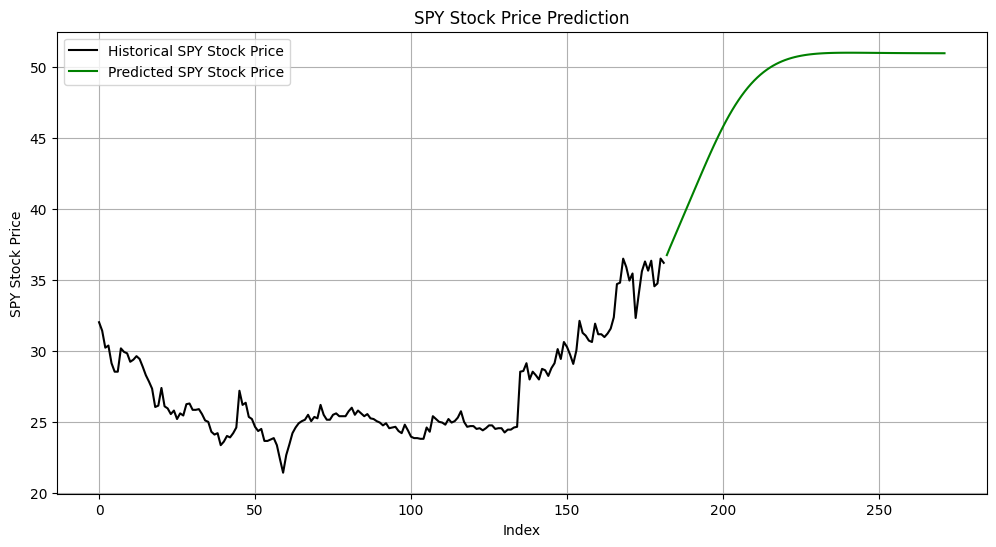

In [40]:
import matplotlib.pyplot as plt

# Assuming you have historical data for the past and predicted data for the next 90 data points
# Define historical data and predicted prices (adjust these as needed)
historical_data = spy_test['Adj Close'].values.reshape(-1, 1)
predicted_prices = future_predictions  # Take the first 90 predicted prices

# Create indices for historical and predicted data
historical_indices = range(len(historical_data))
predicted_indices = range(len(historical_data), len(historical_data) + len(predicted_prices))

# Visualize historical and predicted data on the same plot
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(historical_indices, historical_data, color='black', label='Historical SPY Stock Price')

# Plot predicted data
plt.plot(predicted_indices, predicted_prices, color='green', label='Predicted SPY Stock Price')

plt.title('SPY Stock Price Prediction')
plt.xlabel('Index')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.grid(True)  # Add gridlines for better visualization
plt.show()
